In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm
from NN_Models import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = torch.load('data/X_author_train.pt')
y_train = torch.load('data/y_train.pt')
# X_train = torch.load('data/X_author_all.pt')
# y_train = torch.load('data/y_all.pt')

X_test = torch.load('data/X_author_test.pt')
y_test = torch.load('data/y_test.pt')

In [3]:
# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

100%|██████████| 100/100 [1:05:19<00:00, 39.19s/it]


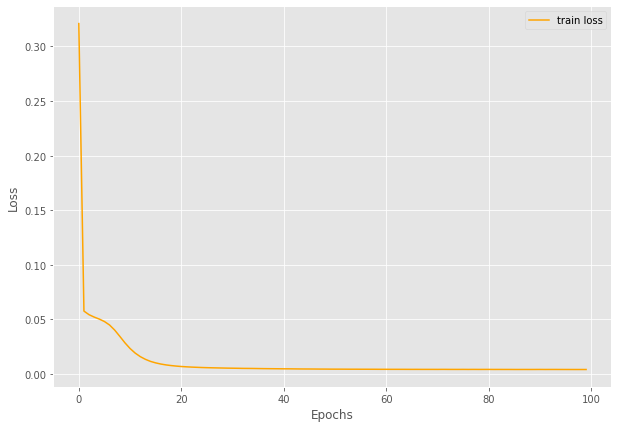

In [4]:
import torch.optim as optim

model = Model()
model.coauthor_model()

learning_rate = 0.001
optimizer = optim.Adam(params=model.coauthor_model().parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
epochs = 100
model.train(train_dataloader, optimizer, epochs)

model.save_status("coauthor")
model.plot_loss()

### Test (ignore when submit kaggle)

In [6]:
from evaluation import evaluation

# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

f1_scores = evaluation(model.model, X_test, y_test, thresholds)

[INFO]: Number of testing samples: 3086
[INFO]: Number of testing features: 21146


100%|██████████| 9/9 [03:14<00:00, 21.60s/it]


In [7]:
print(thresholds[f1_scores.index(max(f1_scores))])
print(max(f1_scores))

# print(f1_scores[thresholds.index(0.5)])

0.3
0.6091036312679513


In [5]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

# X_kaggle = for_kaggle('year_venue')

kaggle_predict(model.model, X_train, 'author_train')
kaggle_predict(model.model, X_test, 'author_test')

100%|██████████| 3086/3086 [00:15<00:00, 201.76it/s]


# Kaggle Predictions

In [27]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

X_kaggle = for_kaggle('coauthor')

kaggle_predict(model.model, X_train, 'author_all')
kaggle_predict(model.model, X_kaggle, 'author')

100%|██████████| 800/800 [00:06<00:00, 129.46it/s]
